In [11]:
import numpy as np
import os
import shutil
import time
import pinecone
from langchain.chains import ConversationalRetrievalChain, ConversationChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers.txt import TextParser
from langchain.memory import VectorStoreRetrieverMemory
from langchain.prompts import PromptTemplate
from langchain.text_splitter import Language, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Pinecone as PineconeVectorStore
import matplotlib.pyplot as plt

Set up environment to have access to Pinecone and OpenAI

In [3]:
os.environ["OPENAI_API_KEY"] = ''
os.environ['PINECONE_API_KEY'] = ''

Initalize a pincone object

In [4]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key='')

Create indexes to store our data 

In [6]:
# create an index in Pinecone storage
index_name = "testing2"

# if index_name not in pc.list_indexes():
#     pc.create_index(
#         name=index_name,
#         dimension=1536,  # Set to the dimension of OpenAI's ada-002 embeddings
#         metric="euclidean", 
#         spec=ServerlessSpec(
#             cloud='aws', 
#             region='us-east-1'
#         )
#     )

Data Preprocessing, generating embedding, and indexing

In [8]:
# Parse markdown documents and split them into text chunks
documentation_path = "/Users/sihamargaw/Desktop/langchain/docs"
# this loader will be used to load the .mdx files from the path
loader = GenericLoader.from_filesystem(
    documentation_path,
    glob="**/*",
    suffixes=[".mdx"],
    parser=TextParser()
)
# this splitter will be used to split the documents into size 1000 text chunks
splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN,
    chunk_size=1000,
    chunk_overlap=100
)
# load the documents using the loader created
documents = loader.load()
print(f"Number of raw documents loaded: {len(documents)}")

# split the documents using the splitter created
documents = splitter.split_documents(documents)
documents = [d for d in documents if len(d.page_content) > 5]
texts = [d.page_content for d in  documents]

# Initalize our embedding model
t1 = time.time()
embedding = OpenAIEmbeddings()

# Embedd the text chunks and store them in PineConeDB
vectorstore = PineconeVectorStore.from_documents(
    documents=documents,
    embedding=embedding,
    index_name=index_name,
    namespace="langchain-namespace"
)
t2 = time.time()
print(f"Embedd the text chunks and stored them in Pinecone DB, Total time: {(t2-t1)}s")

Number of raw documents loaded: 319
Embedd the text chunks and stored them in Pinecone DB, Total time: 44.870620012283325s


Retrieve data

In [9]:
# Initialize LLM
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    temperature=0
)

# Use pinecone storage we setup as retriver in vector search
retriever = vectorstore.as_retriever()
# Use Langchain framework(ConversationalRetrievalChain a class in langchain) to make the backend for the LLM the retriver in our case it's PineCone
private_chatgpt = ConversationalRetrievalChain.from_llm(llm, retriever=retriever)

# Perform similarity search
question = "What is langchain?"

start_time = time.time() # Measure latency for retrieval
response = private_chatgpt.run({'question': question, 'chat_history': ''})
end_time = time.time()

# Calculate TileDB’s latency when retrieving data.
total_latency = end_time - start_time

print(f"User: {question}")
print(f"AI: {response}\n")
print(f"Total Latency for Retrieval: {total_latency} seconds")

/var/folders/ym/q12h1czs7935v9b665jkynvh0000gn/T/ipykernel_82253/1355653535.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
/var/folders/ym/q12h1czs7935v9b665jkynvh0000gn/T/ipykernel_82253/1355653535.py:16: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = private_chatgpt.run({'question': question, 'chat_history': ''})


User: What is langchain?
AI: LangChain is a framework for developing applications powered by large language models (LLMs). It simplifies every stage of the LLM application lifecycle, including development, productionization, and deployment.

Total Latency for Retrieval: 1.6411020755767822 seconds


For different question formulations record time taken for retrieval

In [3]:
questions = [
    "What is LangChain?",
    "Can you explain LangChain?",
    "Describe the functionality of LangChain.",
    "What are the main features of LangChain?",
    "How does LangChain work?",
    "Can you provide an overview of LangChain?",
]

# Dictionary to store latencies for each question
latency_results_pinecone = {}

# Iterate over each question, measure latency, and store the results
for question in questions:
    print(f"Processing question: {question}")
    start_time = time.time()
    response = private_chatgpt.run({'question': question, 'chat_history': ''})
    end_time = time.time()
    latency = end_time - start_time
    latency_results_pinecone[question] = latency
    print(f"Latency for '{question}': {latency:.4f} seconds")


Processing question: What is LangChain?
Latency for 'What is LangChain?': 1.7621 seconds
Processing question: Can you explain LangChain?
Latency for 'Can you explain LangChain?': 2.1442 seconds
Processing question: Describe the functionality of LangChain.
Latency for 'Describe the functionality of LangChain.': 2.1525 seconds
Processing question: What are the main features of LangChain?
Latency for 'What are the main features of LangChain?': 2.2498 seconds
Processing question: How does LangChain work?
Latency for 'How does LangChain work?': 3.0727 seconds
Processing question: Can you provide an overview of LangChain?
Latency for 'Can you provide an overview of LangChain?': 2.1507 seconds


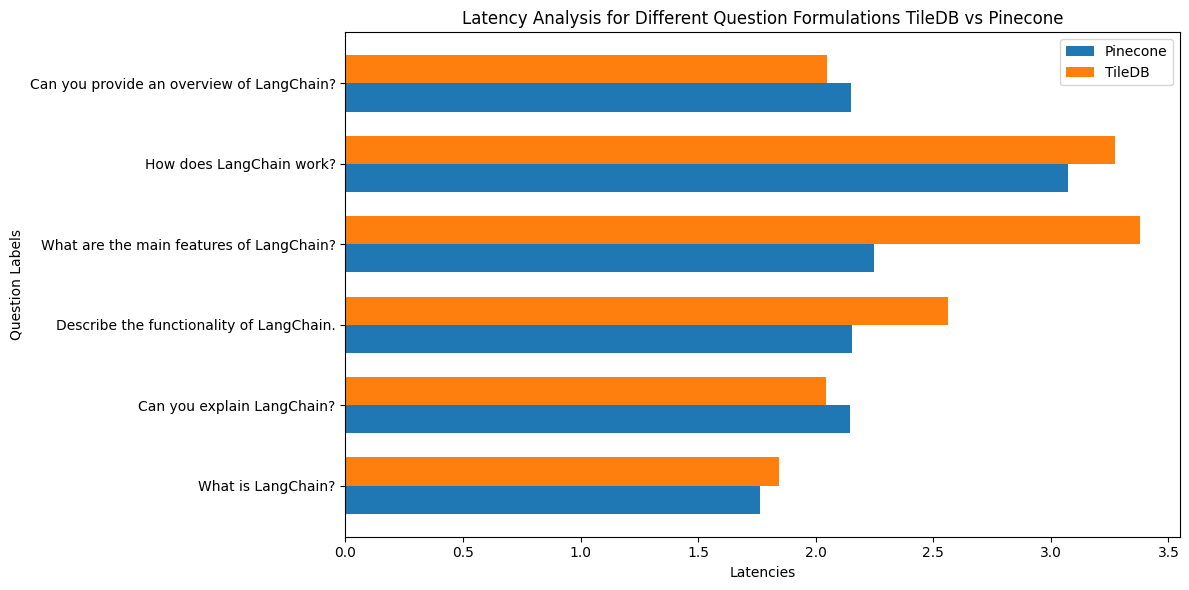

In [9]:
# Plotting the results
questions_labels = list(latency_results_pinecone.keys())
latencies_pinecone = list(latency_results_pinecone.values())
latencies_tiledb = list(latency_results_tileDB.values())

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))

# Set bar height
bar_height = 0.35

# Set y positions for bars
y = np.arange(len(questions_labels))

# Plot bars
ax.barh(y - bar_height/2, latencies_pinecone, bar_height, label='Pinecone')
ax.barh(y + bar_height/2, latencies_tiledb, bar_height, label='TileDB')

# Set title and labels
ax.set_title('Latency Analysis for Different Question Formulations TileDB vs Pinecone')
ax.set_ylabel('Question Labels')
ax.set_xlabel('Latencies')

# Set yticks
ax.set_yticks(y)
ax.set_yticklabels(questions_labels)

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()